In [1]:
from __future__ import print_function

In [2]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(1)

batch_size = 32
class_map = {
    'ZERO': 0,
    'ONE': 1,
    'TWO': 2,
    'THREE': 3,
    'FOUR': 4,
    'FIVE': 5,
    'SIX': 6,
    'SEVEN': 7,
    'EIGHT': 8,
    'NINE': 9
}
show_summary = True
show_dataset_analyze = False

In [3]:
# Load Network and Print Summary
from mnist.model import Net
from mnist.utils import get_device, print_summary

# Check GPU availability
use_cuda, device = get_device()

if show_summary:
    model = Net(norm='bn').to(device)
    print_summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
       BatchNorm2d-2            [-1, 4, 28, 28]               8
            Conv2d-3            [-1, 4, 28, 28]             148
       BatchNorm2d-4            [-1, 4, 28, 28]               8
            Conv2d-5            [-1, 4, 28, 28]             148
       BatchNorm2d-6            [-1, 4, 28, 28]               8
         MaxPool2d-7            [-1, 4, 14, 14]               0
           Dropout-8            [-1, 4, 14, 14]               0
            Conv2d-9            [-1, 8, 14, 14]             296
      BatchNorm2d-10            [-1, 8, 14, 14]              16
           Conv2d-11            [-1, 8, 14, 14]             584
      BatchNorm2d-12            [-1, 8, 14, 14]              16
           Conv2d-13            [-1, 8, 14, 14]             584
      BatchNorm2d-14            [-1, 8,

In [4]:
from mnist.dataset import get_loader
from mnist.transform import get_a_train_transform, get_a_test_transform

train_loader, test_loader = get_loader(get_a_train_transform(), get_a_test_transform(), batch_size=batch_size, use_cuda=use_cuda)

In [5]:
## Calculate Class Scale
from mnist.visualize import print_class_scale, print_samples
if show_dataset_analyze:
    print_class_scale(train_loader, class_map)
    print_samples(train_loader)

In [6]:
import time
import math

from mnist.backpropagation import train, test, get_sgd_optimizer
from mnist.utils import initialize_weights
from mnist.scheduler import one_cycle_lr_pt, one_cycle_lr_custom
from mnist.training import Training

# Train Params
epochs = 15
lr = 0.05
max_lr = 0.1
steps_per_epoch = len(train_loader)
dropout = True
momentum = 0.9
weight_decay = 0

print("Using Device:", device)
print("Epochs:", epochs)
print("Lr:", lr)
print("Max Lr:", max_lr)
print("Batch Size:", batch_size)
print("Dropout:", dropout)
print("\n")

model = Net(norm='bn').apply(initialize_weights).to(device)
optimizer = get_sgd_optimizer(model, lr=lr)

# Pytorch one cycle scheduler
pytorch_scheduler = one_cycle_lr_pt(
    optimizer, 
    lr=lr, 
    max_lr=max_lr, 
    steps_per_epoch=steps_per_epoch, 
    epochs=epochs, 
    anneal_strategy='linear'
)

# One cycle schedule with custome function
custom_scheduler = one_cycle_lr_custom(
    optimizer, 
    lr=lr, 
    max_lr=max_lr, 
    steps_per_epoch=steps_per_epoch, 
    epochs=epochs, 
    anneal_strategy='linear'
)

trainer = Training(
    model,
    optimizer,
    custom_scheduler,
    train,
    test,
    train_loader,
    test_loader,
    lr,
    epochs,
    device,
    dropout
)

trainer.run()

Using Device: cuda
Epochs: 15
Lr: 0.05
Max Lr: 0.1
Batch Size: 32
Dropout: True


Epoch: 01
	 Learning Rate: 0.050000
	          Time: 0m 12s
	    Train Loss: 0.336343
	Train Accuracy: 53644/60000 | Percent: 89.41%
	     Val. Loss: 0.117156
	  Val Accuracy:  9648/10000 | Percent: 96.48%
Epoch: 02
	 Learning Rate: 0.075000
	          Time: 0m 12s
	    Train Loss: 0.135993
	Train Accuracy: 57569/60000 | Percent: 95.95%
	     Val. Loss: 0.079234
	  Val Accuracy:  9734/10000 | Percent: 97.34%
Epoch: 03
	 Learning Rate: 0.100000
	          Time: 0m 12s
	    Train Loss: 0.111134
	Train Accuracy: 58041/60000 | Percent: 96.73%
	     Val. Loss: 0.064190
	  Val Accuracy:  9801/10000 | Percent: 98.01%
Epoch: 04
	 Learning Rate: 0.085000
	          Time: 0m 12s
	    Train Loss: 0.078485
	Train Accuracy: 58618/60000 | Percent: 97.70%
	     Val. Loss: 0.035311
	  Val Accuracy:  9880/10000 | Percent: 98.80%
Epoch: 05
	 Learning Rate: 0.070000
	          Time: 0m 12s
	    Train Loss: 0.067728
	Train A

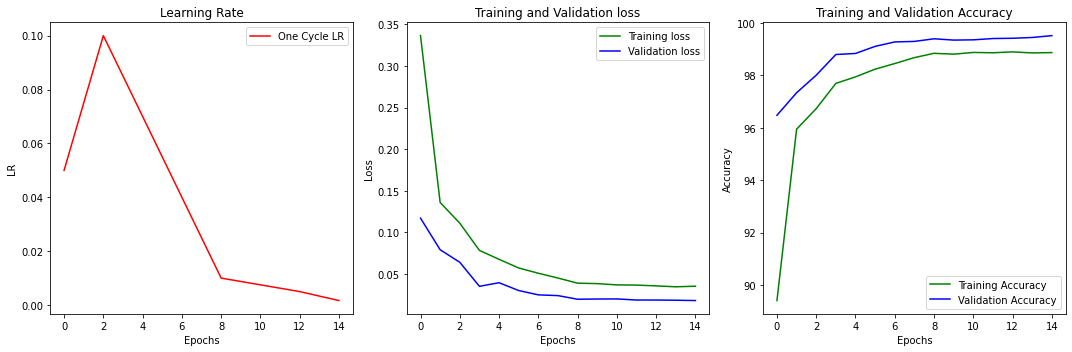

In [7]:
from mnist.visualize import plot_network_performance

# trainer.print_best_model()
plot_network_performance(epochs, trainer.schedule, trainer.list_train_loss, trainer.list_valid_loss, trainer.list_train_correct, trainer.list_valid_correct)

## Analyze Network

Confusion matrix, without normalization


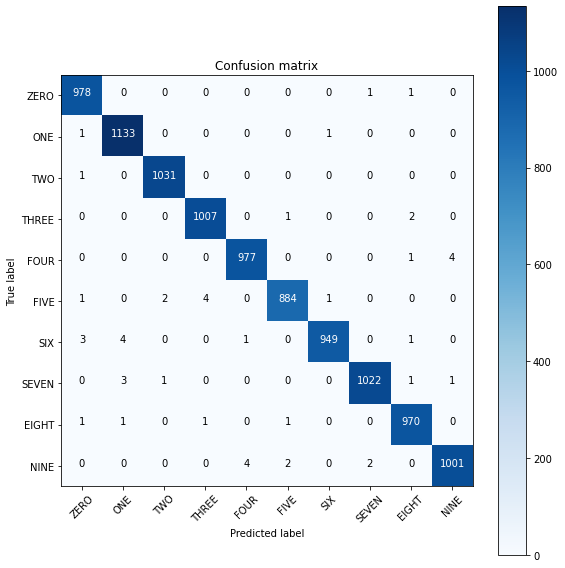

In [8]:
from mnist.utils import get_all_predictions, get_incorrrect_predictions, prepare_confusion_matrix
from mnist.visualize import plot_confusion_matrix

all_preds, all_targets = get_all_predictions(model, test_loader, device)
confusion_matrix = prepare_confusion_matrix(all_preds, all_targets, class_map)
plot_confusion_matrix(confusion_matrix, class_map, False)

Total Incorrect Predictions 48


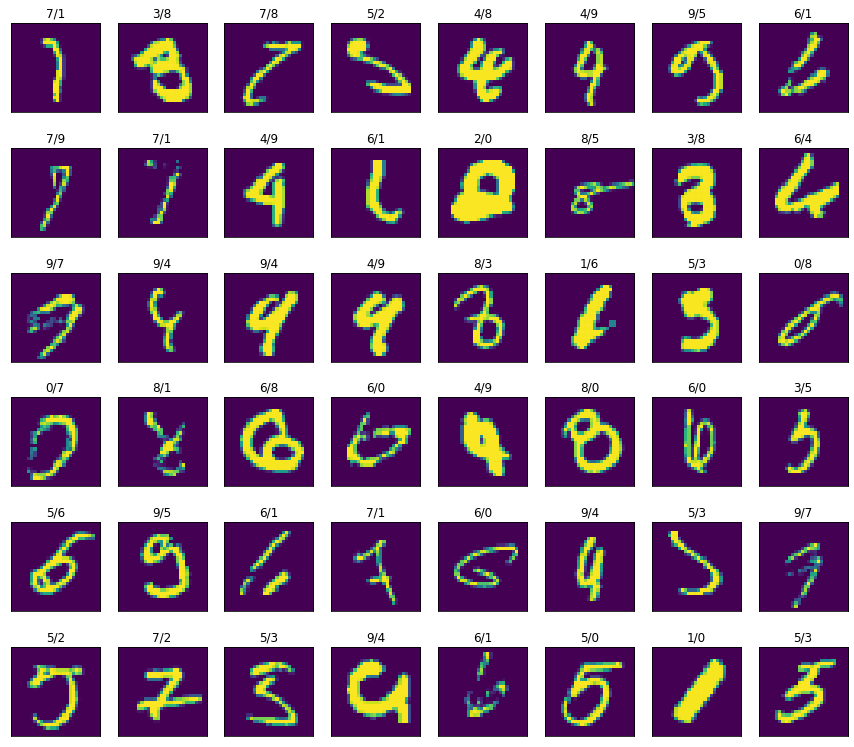

In [9]:
from mnist.utils import get_incorrrect_predictions
from mnist.visualize import plot_incorrect_predictions

incorrect = get_incorrrect_predictions(model, test_loader, device)
plot_incorrect_predictions(incorrect, class_map)